In [14]:
import os 
import pandas as pd 
import numpy as np 


In [15]:
df = pd.read_csv('BigLlama3_1Model.csv', index_col=0)

In [16]:
import re 

def create_distance_matrix(str1, str2):
    # Split the strings into words
    str1 = str1.split(' ')
    str2 = str2.split(' ')

    # Initialize the matrix
    m, n = len(str1), len(str2)
    matrix = np.zeros((m + 1, n + 1), dtype=int)

    # Fill the first row and first column
    for i in range(1, m + 1):
        matrix[i][0] = i
    for j in range(1, n + 1):
        matrix[0][j] = j

    # Fill the matrix with edit distances
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if str1[i - 1] == str2[j - 1]:
                matrix[i][j] = matrix[i - 1][j - 1]
            else:
                matrix[i][j] = 1 + min(matrix[i - 1][j], matrix[i][j - 1], matrix[i - 1][j - 1])

    # Create a DataFrame to include the words in the headers
    df = pd.DataFrame(matrix, index=[""] + str1, columns=[""] + str2)
    return df

def trace_path(matrix, str1, str2):
    m, n = len(str1), len(str2)
    i, j = m, n
    deleted = []
    added = []
    unchanged = []

    while i > 0 or j > 0:
        if i > 0 and j > 0 and str1[i - 1, 1] == str2[j - 1]:
            unchanged.append(str1[i - 1, :])
            i -= 1
            j -= 1
        elif i > 0 and (j == 0 or matrix.iloc[i, j] == matrix.iloc[i - 1, j] + 1):
            deleted.append(str1[i - 1, :])
            i -= 1
        elif j > 0 and (i == 0 or matrix.iloc[i, j] == matrix.iloc[i, j - 1] + 1):
            added.append(str2[j - 1])
            j -= 1
        else:
            deleted.append(str1[i - 1, :])
            added.append(str2[j - 1])
            i -= 1
            j -= 1

    return deleted[::-1], added[::-1], unchanged[::-1]  # Reverse the lists to have the correct order


def calc_precision_and_recall(list_of_ground_truth_labels, list_of_generated_labels):
    # Check if inputs are lists
    # if not isinstance(list_of_ground_truth_labels, list) or not isinstance(list_of_generated_labels, list):
    #     raise TypeError("Both inputs must be lists")

    str1 = ' '.join(list_of_ground_truth_labels[:,1])
    str2 = ' '.join(list_of_generated_labels)

    # Create the distance matrix
    matrix = create_distance_matrix(str1, str2)

    # Trace the minimum path and get the operations
    # added_words, deleted_words, unchanged_words = trace_path(matrix, list_of_ground_truth_labels, str2.split(' '))
    return trace_path(matrix, list_of_ground_truth_labels, str2.split(' '))
    FN = len(added_words)
    FP = len(deleted_words)
    TP = len(unchanged_words)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1


def evaluate(masked, generated):
    """ 
    Input: 
        - masked (str): Ground_truth text
        - generated(str): Text to be evaluated

    Output:
        - Precision, Recall and F1 (float)
    """
    ground_truth = re.findall(r'\[\*\*(.*?)\*\*\]', masked)
    predictions = re.findall(r'\[\*\*(.*?)\*\*\]', generated)

    labels = [ground_truth, predictions]

    return [calc_precision_and_recall(ground_truth, predictions), labels]

In [17]:
df = df.loc[df.fail != 1]

In [18]:
df

,filename,precision,recall,f1,cos,levenshtein,ground_truth,generated,inv_levenshtein,overall,fail
0,CARMEN-I_CC_1.txt,0.842105,1.000000,0.914286,0.988818,3.0,"['hilandero', 'suegro', '2 yernos', '8/9/21', ...","['hilandero', 'suegro', '2 yernos', '8/9/21', ...",0.333333,4.078543,NaN
1,CARMEN-I_CC_1.txt,0.842105,1.000000,0.914286,0.988818,3.0,"['hilandero', 'suegro', '2 yernos', '8/9/21', ...","['hilandero', 'suegro', '2 yernos', '8/9/21', ...",0.333333,4.078543,NaN
3,CARMEN-I_CC_3.txt,0.750000,1.000000,0.857143,1.000000,5.0,"['2017', 'abril', '1/01/2018']","['medico de cabecera', '2017', 'abril de este ...",0.200000,3.807143,NaN
4,CARMEN-I_CC_3.txt,0.750000,1.000000,0.857143,1.000000,5.0,"['2017', 'abril', '1/01/2018']","['medico de cabecera', '2017', 'abril de este ...",0.200000,3.807143,NaN
5,CARMEN-I_CC_4.txt,0.947368,0.947368,0.947368,0.999182,6.0,"['Técnico informático', 'cónyuge', '11/3', '11...","['Técnico informático', 'cónyuge', '11/3', '11...",0.166667,4.007954,NaN
...,...,...,...,...,...,...,...,...,...,...,...
226,CARMEN-I_IA_ANTECEDENTES_86.txt,0.954545,1.000000,0.976744,1.000000,2.0,"['Hombre', '50', 'Arequipa', 'República del Pe...","['Hombre', '50', 'Arequipa', 'República del Pe...",0.500000,4.431290,NaN
227,CARMEN-I_IA_ANTECEDENTES_87.txt,0.700000,1.000000,0.823529,1.000000,1.0,"['Varón', '81 años', 'recepcionista de hotel',...","['Varón', '81 años', 'recepcionista de hotel',...",1.000000,4.523529,NaN
228,CARMEN-I_IA_ANTECEDENTES_87.txt,0.700000,1.000000,0.823529,1.000000,1.0,"['Varón', '81 años', 'recepcionista de hotel',...","['Varón', '81 años', 'recepcionista de hotel',...",1.000000,4.523529,NaN
229,CARMEN-I_IA_ANTECEDENTES_88.txt,1.000000,1.000000,1.000000,1.000000,1.0,"['Hombre', '79 años', 'junio de 2008', '03/201...","['Hombre', '79 años', 'junio de 2008', '03/201...",1.000000,5.000000,NaN


In [19]:
from tqdm import tqdm 

labels_escapadas = []
labels_acertadas = []

for n in tqdm(range(len(df))):
    labels = pd.read_csv(os.path.join('data', 'processed', 'ann', df.iloc[n].filename.replace('txt', 'csv')), header=None)
    aux = []

    for i in range(len(labels)):
        for j in range(len(labels.iloc[i][3].split(' '))):
            aux.append([labels.iloc[i][0], labels.iloc[i][3].split(' ')[j]])



    total_labels = len(aux)
    escaparon, _ , acerto =  calc_precision_and_recall(np.array(aux), eval(df.iloc[n]['generated']))
    for line in escaparon:
        labels_escapadas.append(line)
    for line in acerto:
        labels_acertadas.append(line)

labels_escapadas = np.array(labels_escapadas)
labels_acertadas = np.array(labels_acertadas)


100%|██████████| 200/200 [00:01<00:00, 112.10it/s]


In [20]:
missing_label, missing_amount = np.unique(labels_escapadas[:,0], return_counts=True)
finded_label, finded_amount = np.unique(labels_acertadas[:,0], return_counts=True)

In [21]:
missing = {}
for n, label in enumerate(missing_label):
    missing[label] = missing_amount[n]

finded = {}
for n, label in enumerate(finded_label):
    finded[label] = finded_amount[n]

    
metrics = {}

for key in np.unique(missing_label.tolist() + finded_label.tolist()):
    acierto = finded.get(key, None)
    error = missing.get(key, None)

    if acierto == None:
        metrics[key] = 0
    elif error == None: 
        metrics[key] = 1.0
    else:
        metrics[key] = acierto/(acierto+error)

In [22]:
metrics

{'CENTRO_SALUD': 1.0,
 'EDAD_SUJETO_ASISTENCIA': 1.0,
 'FAMILIARES_SUJETO_ASISTENCIA': 0.8615384615384616,
 'FECHAS': 0.9348914858096828,
 'HOSPITAL': 1.0,
 'ID_SUJETO_ASISTENCIA': 1.0,
 'INSTITUCION': 0.8,
 'NOMBRE_PERSONAL_SANITARIO': 1.0,
 'NUMERO_IDENTIF': 0,
 'NUMERO_TELEFONO': 1.0,
 'OTROS_SUJETO_ASISTENCIA': 0.18181818181818182,
 'PAIS': 0.9819819819819819,
 'PROFESION': 0.75,
 'SEXO_SUJETO_ASISTENCIA': 0.9571428571428572,
 'TERRITORIO': 0.9836065573770492}

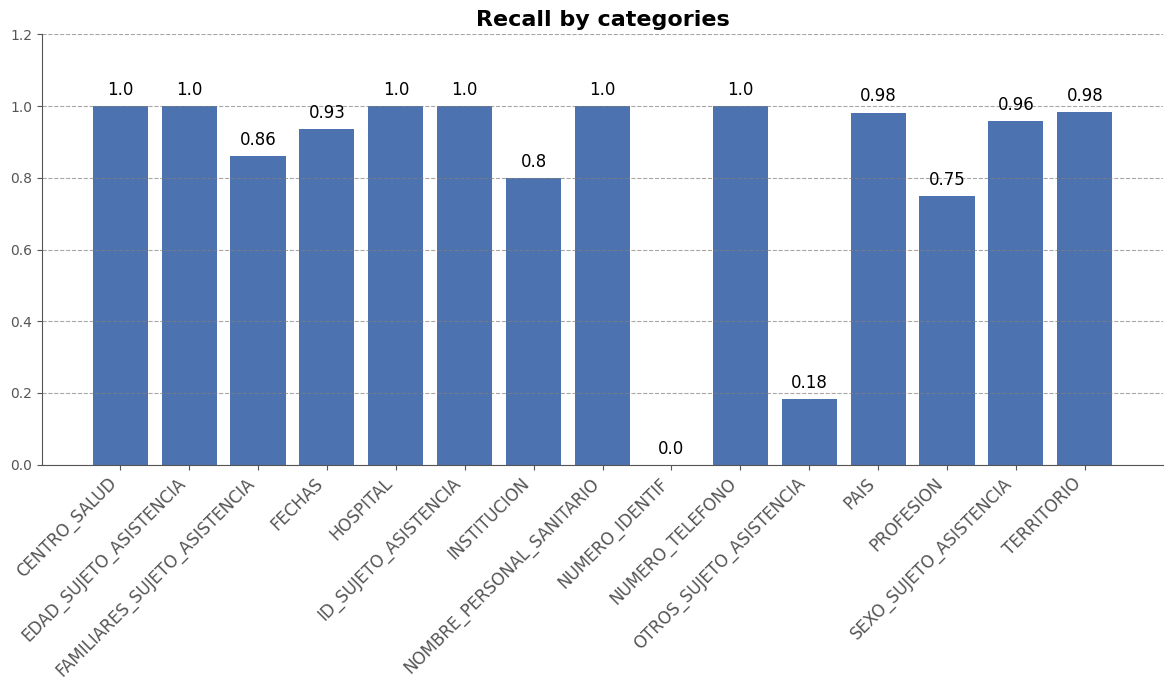

In [28]:
import matplotlib.pyplot as plt


# Crear listas de claves y valores
clases = list(metrics.keys())
valores = list(metrics.values())

# Crear la gráfica
plt.figure(figsize=(12, 7))

# Usar un solo color para todas las barras
bars = plt.bar(clases, valores, color='#4C72B0')

# Añadir etiquetas de valores encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom', fontsize=12)

# Añadir títulos y etiquetas con estilo
plt.title('Recall by categories', fontsize=16, fontweight='bold')

# Inclinar los nombres de las clases para mejor legibilidad
plt.xticks(rotation=45, ha='right', fontsize=12)

# Mejorar el estilo del fondo y de los ejes
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color('#555555')
plt.gca().spines['bottom'].set_color('#555555')
plt.gca().tick_params(axis='x', colors='#555555')
plt.gca().tick_params(axis='y', colors='#555555')

plt.ylim(0, 1.2)  # Asegurar que el eje y vaya de 0 a 1

# Añadir una cuadrícula de fondo sutil
plt.grid(True, which='both', axis='y', linestyle='--', color='gray', alpha=0.7)

# Mostrar la gráfica
plt.tight_layout()  # Asegura que todo se ajuste bien dentro del área de la figura
plt.show()
